In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')


project_path = "/content/drive/MyDrive/DIP_Project/"
degraded_dir = os.path.join(project_path, "degraded/")
preprocessed_dir = os.path.join(project_path, "preprocessed/")
robin_input_dir = os.path.join(project_path, "robin_input/")
robin_output_dir = os.path.join(project_path, "robin_output/")

for folder in [degraded_dir, preprocessed_dir, robin_input_dir, robin_output_dir]:
    os.makedirs(folder, exist_ok=True)

print("Google Drive mounted and folders ready.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted and folders ready.


In [ ]:
!pip install opencv-python-headless scikit-image matplotlib


In [ ]:
import cv2
import numpy as np

def preprocess_image(path, save_path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Gaussian Blur
    blur = cv2.GaussianBlur(img, (5,5), 0)

    # Otsu Thresholding
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological Closing
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

    cv2.imwrite(save_path, morph)


for fname in os.listdir(degraded_dir):
    if fname.endswith(".png"):
        in_path = os.path.join(degraded_dir, fname)
        out_path = os.path.join(preprocessed_dir, fname)
        preprocess_image(in_path, out_path)

print("DIP preprocessing completed. Files saved in:", preprocessed_dir)


DIP preprocessing completed. Files saved in: /content/drive/MyDrive/DIP_Project/preprocessed/


In [ ]:
%cd /content
!git clone https://github.com/masyagin1998/robin.git
%cd robin
!pip install -r requirements.txt

# Download pretrained weights
!wget -O model_weights.zip https://www.dropbox.com/s/vrlcbdhfbvn82pi/model_weights.zip?dl=1
!unzip model_weights.zip -d model_weights


/content
fatal: destination path 'robin' already exists and is not an empty directory.
/content/robin
  Using cached numpy-1.22.0.zip (11.3 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
--2025-10-03 17:09:26--  https://www.dropbox.com/s/vrlcbdhfbvn82pi/model_weights.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response...

In [ ]:
import shutil
for fname in os.listdir(preprocessed_dir):
    if fname.endswith(".png"):
        shutil.copy(os.path.join(preprocessed_dir, fname), robin_input_dir)


In [ ]:
!python /content/robin/src/unet/binarize.py \
  --input "{robin_input_dir}" \
  --output "{robin_output_dir}" \
  --weights "/content/robin/model_weights/model_weights/Robin/bin_weights.hdf5"


2025-10-03 17:28:04.125337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759512484.159686   24885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759512484.170058   24885 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759512484.198292   24885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759512484.198339   24885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759512484.198348   24885 computation_placer.cc:177] computation placer alr

Plotting 14 images...


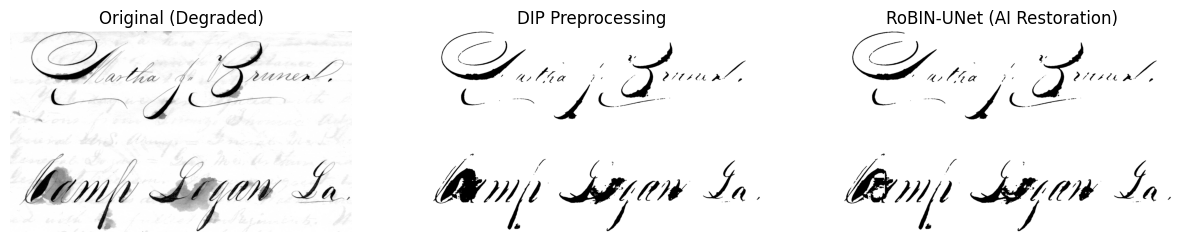

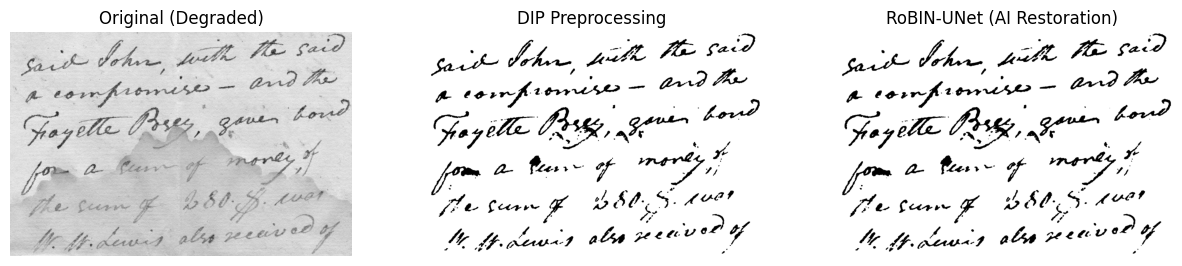

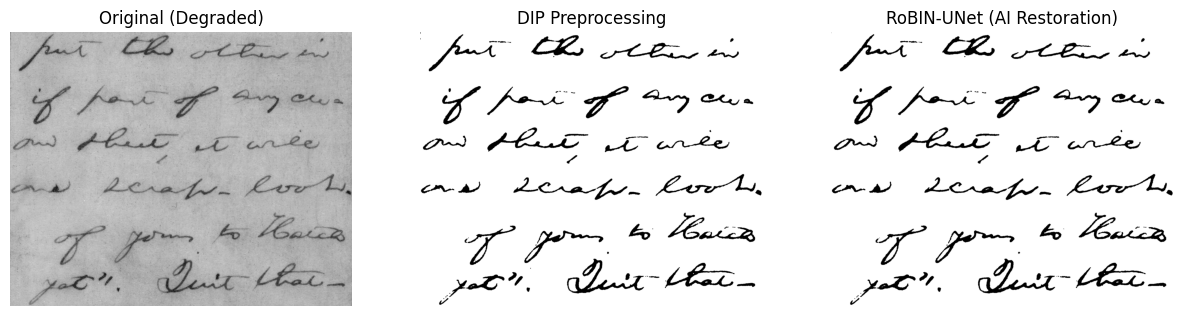

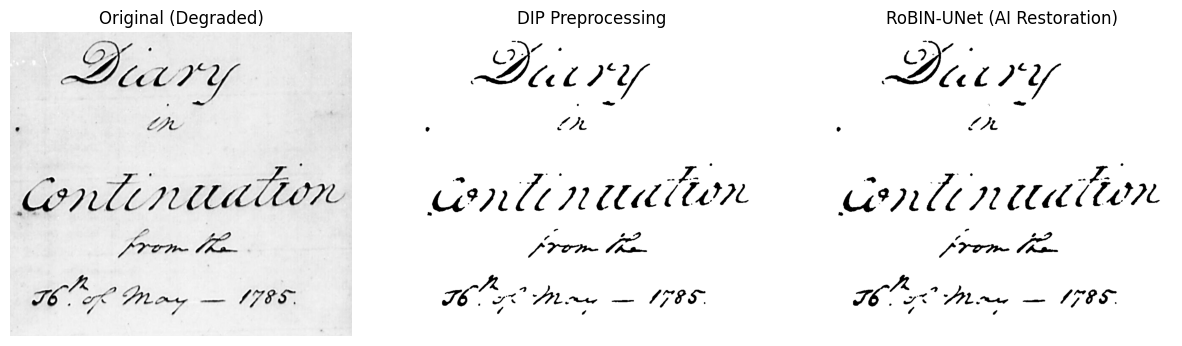

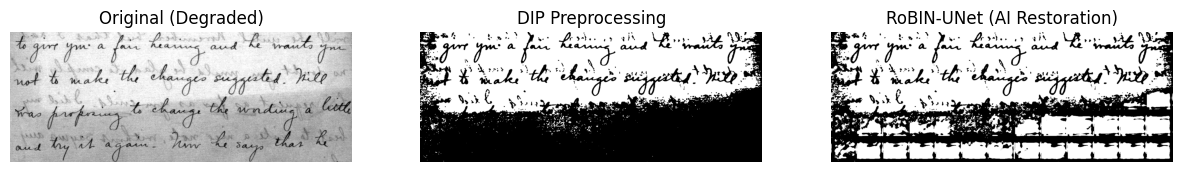

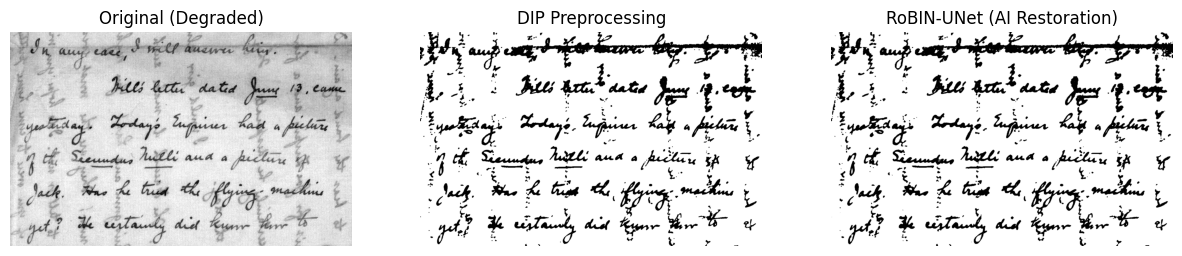

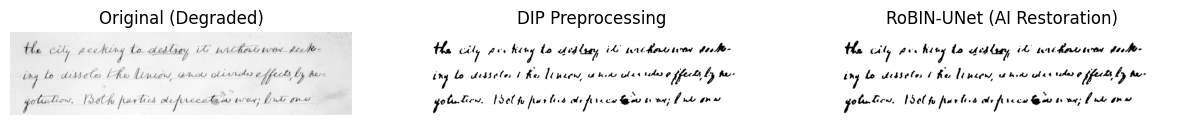

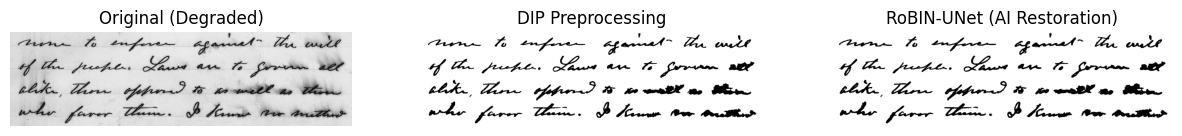

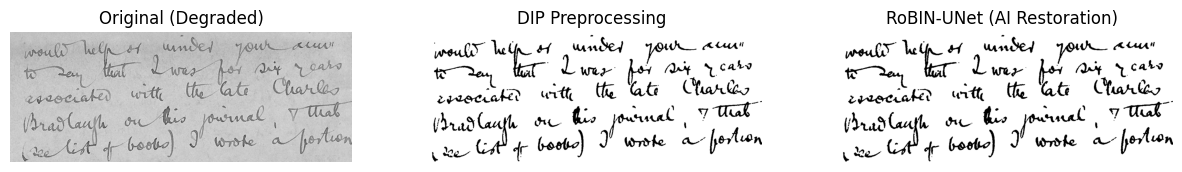

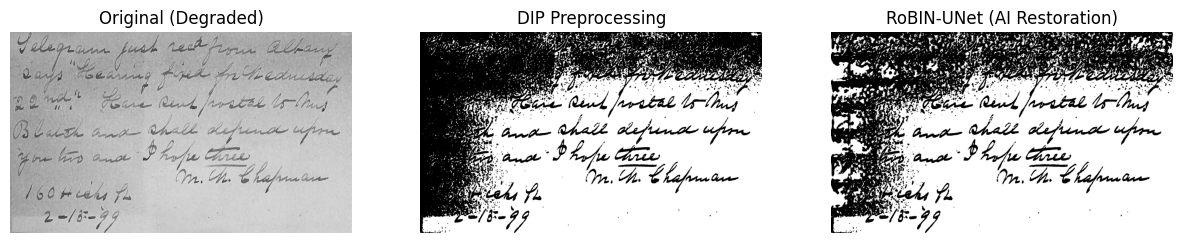

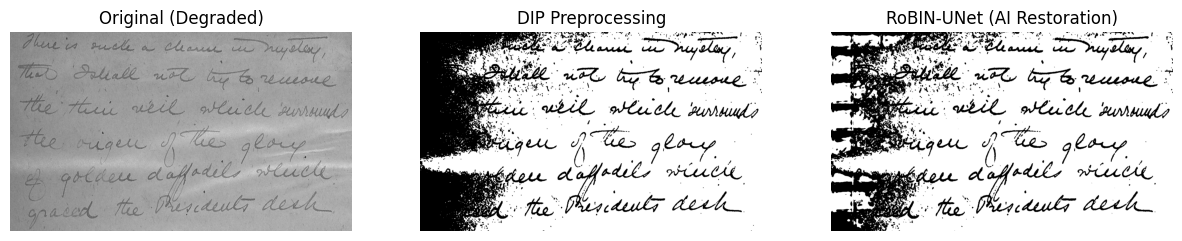

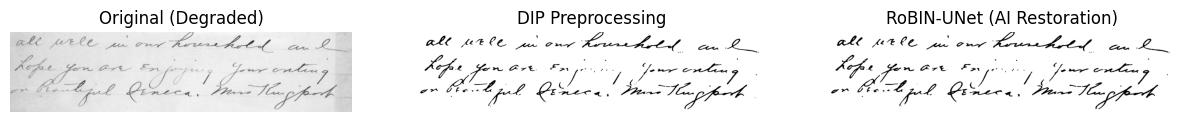

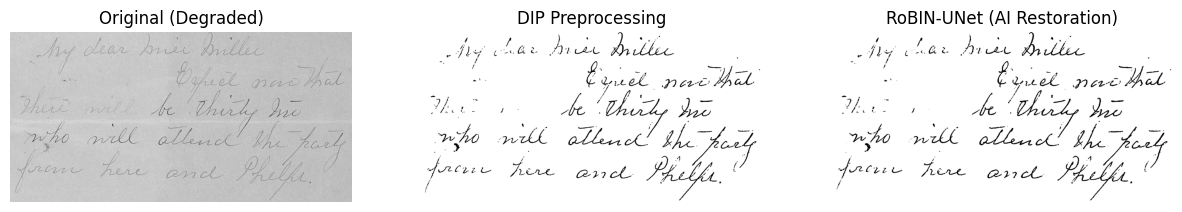

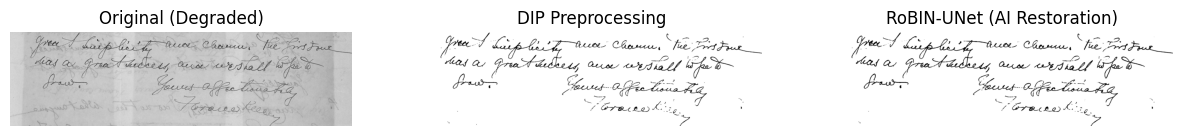

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Folders
orig_folder = "/content/drive/MyDrive/DIP_Project/degraded"
dip_folder = "/content/drive/MyDrive/DIP_Project/robin_input"
robin_folder = "/content/drive/MyDrive/DIP_Project/robin_output"

# Get sorted lists of image filenames
orig_files = sorted([f for f in os.listdir(orig_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
dip_files = sorted([f for f in os.listdir(dip_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
robin_files = sorted([f for f in os.listdir(robin_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Make sure all folders have the same number of images
num_images = min(len(orig_files), len(dip_files), len(robin_files))
print(f"Plotting {num_images} images...")

for i in range(num_images):
    # Read images safely
    orig_path = os.path.join(orig_folder, orig_files[i])
    dip_path = os.path.join(dip_folder, dip_files[i])
    robin_path = os.path.join(robin_folder, robin_files[i])

    orig = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
    dip = cv2.imread(dip_path, cv2.IMREAD_GRAYSCALE)
    robin = cv2.imread(robin_path, cv2.IMREAD_GRAYSCALE)

    if orig is None:
        print(f"Warning: Cannot read original image: {orig_files[i]}")
        continue
    if dip is None:
        print(f"Warning: Cannot read DIP image: {dip_files[i]}")
        continue
    if robin is None:
        print(f"Warning: Cannot read RoBIN image: {robin_files[i]}")
        continue

    # Plot images side by side
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(orig, cmap="gray")
    plt.title("Original (Degraded)")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(dip, cmap="gray")
    plt.title("DIP Preprocessing")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(robin, cmap="gray")
    plt.title("RoBIN-UNet (AI Restoration)")
    plt.axis('off')

    plt.show()


In [ ]:
import os
import shutil
from google.colab import drive

# --- CONFIGURATION ---
# 1. Name of the folder you want to copy from the Colab runtime
FOLDER_TO_COPY = "robin"  # <-- Make sure this matches your actual output folder name

# 2. Path in your Google Drive where you want to place the folder
# Set to 'DIP_Project' to create or use a folder named 'DIP_Project' directly under My Drive.
DESTINATION_PATH_IN_DRIVE = "DIP_Project"


# --- STEP 1: Mount Google Drive ---
print("--- Step 1: Mounting Google Drive ---")
# This will prompt you to click a link, choose your account, and grant permissions.
drive.mount('/content/drive')
print("Drive mounted successfully at /content/drive/MyDrive")

# --- STEP 2: Verify Source Folder and Define Paths ---
print("\n--- Step 2: Verification and Path Setup ---")

# Define the full source path (in Colab runtime)
source_path = os.path.join("/content", FOLDER_TO_COPY)

# Define the full destination path (in Google Drive)
destination_dir = os.path.join("/content/drive/MyDrive", DESTINATION_PATH_IN_DRIVE)

# Check if the source folder exists
if not os.path.isdir(source_path):
    print(f"ERROR: Source folder not found at: {source_path}")
    print("Please check the FOLDER_TO_COPY variable.")
else:
    print(f"Source folder found: {source_path}")

    # Check if the destination directory exists, if not, create it
    if not os.path.exists(destination_dir):
        print(f"Creating destination directory: {destination_dir}")
        os.makedirs(destination_dir)

    # Define the final destination path for the copied folder
    final_destination_path = os.path.join(destination_dir, FOLDER_TO_COPY)

    # --- STEP 3: Copy the Folder using shell command ---
    print("\n--- Step 3: Copying folder to Google Drive (This may take time) ---")

    # Use the shell command 'cp -r' (copy recursively) for reliable, fast copying
    copy_command = f"cp -r '{source_path}' '{destination_dir}'"

    # Execute the shell command
    !{copy_command}

    # --- STEP 4: Verification ---
    print("\n--- Step 4: Verification ---")
    # Check if the folder now exists in Drive
    if os.path.isdir(os.path.join(destination_dir, FOLDER_TO_COPY)):
        print(f"✅ SUCCESS: Folder '{FOLDER_TO_COPY}' successfully copied to Drive.")
        print(f"Check your Drive at: /My Drive/{DESTINATION_PATH_IN_DRIVE}/{FOLDER_TO_COPY}")
        print("Note: You may need to refresh your Google Drive window.")
    else:
        print("❌ FAILURE: Copy operation failed. Please check permissions and paths.")

--- Step 1: Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully at /content/drive/MyDrive

--- Step 2: Verification and Path Setup ---
Source folder found: /content/robin

--- Step 3: Copying folder to Google Drive (This may take time) ---

--- Step 4: Verification ---
✅ SUCCESS: Folder 'robin' successfully copied to Drive.
Check your Drive at: /My Drive/DIP_Project/robin
Note: You may need to refresh your Google Drive window.
